# Regularization for linear classifier models

In [44]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes, fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

def score(X, y, model, n=10):
    train_scores = []
    test_scores = []
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        model.fit(X_train, y_train)
        train_score = model.score(X_train, y_train)
        train_scores.append(train_score)
        test_score = model.score(X_test, y_test)
        test_scores.append(test_score)
    return np.mean(train_scores), np.mean(test_scores)

def normalize(X): # well, I'm creating standard variables here (u-x)/sigma
    for colname in X.columns:
        u = np.mean(X[colname])
        s = np.std(X[colname])
        X[colname] = (X[colname] - u) / s

In [29]:
def plot_coef(B):
    plt.figure(figsize=(3,3))
    plt.bar(range(len(B)),B)
    plt.xlabel("Regression coefficient $\\beta_i$ for $i>0$", fontsize=12)
    plt.ylabel("Regression coefficient value", fontsize=12)

## Wine data for classes 0,1

In [56]:
wine = load_wine()
df_wine = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df_wine['y'] = wine.target
df_wine = df_wine[df_wine['y']<2]
X = df_wine.drop('y', axis=1)
y = df_wine['y']
print(f"{len(X)} records for classes {{0,1}} from {len(wine.data)} records")

130 records for classes {0,1} from 178 records


### Baseline sklearn no reg

In [57]:
no_regularization = 1/1e10
lm = LogisticRegression(C=no_regularization, solver='lbfgs')
lm.fit(X.values, y)
lm.score(X.values, y)

0.45384615384615384

In [58]:
lm.coef_[0]

array([ 3.09134017e-09,  9.36601059e-10,  7.33778899e-10,  2.16518108e-08,
        2.23291940e-08, -3.49738733e-10, -1.40114627e-09,  4.36657033e-10,
        1.91207094e-10, -5.33343047e-09,  6.20735553e-10,  5.83575212e-10,
       -1.44359992e-06])

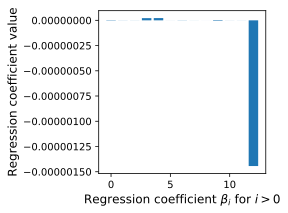

In [59]:
plot_coef(lm.coef_[0])

## normalize and try again

In [60]:
normalize(X)

no_regularization = 1/1e10
lm = LogisticRegression(C=no_regularization, solver='lbfgs')
lm.fit(X.values, y)
lm.score(X.values, y)

0.5461538461538461

In [61]:
lm.coef_[0]

array([-5.33571541e-09, -2.86731332e-10, -2.29472123e-09,  3.04478622e-09,
       -2.47942770e-09, -3.44771828e-09, -3.95279928e-09,  2.18430910e-09,
       -1.61291394e-09, -4.85815825e-09, -1.10304961e-10, -2.53546917e-09,
       -5.47096616e-09])

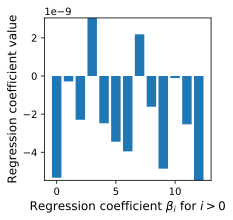

In [62]:
plot_coef(lm.coef_[0])

### With reg

In [63]:
lm = LogisticRegression(solver='lbfgs', max_iter=1000)
lm.fit(X.values, y)
lm.score(X.values, y)

1.0

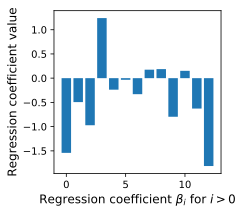

In [64]:
plot_coef(lm.coef_[0])

## MNIST classification

In [9]:
digits = pd.read_csv("../../data/mnist-10k-sample.csv")
images = digits.drop('digit', axis=1) # get just pixels
targets = digits['digit']             # get just digit value

In [10]:
def imgrid(images):
    fig, axes = plt.subplots(5, 5, figsize=(4, 4)) # make 5x5 grid of plots
    for i, ax in enumerate(axes.flat):
        img_as_row = images.iloc[i].values
        img28x28 = img_as_row.reshape(28,28)
        ax.axis('off') # don't show x, y axes
        ax.imshow(img28x28, cmap='Greys')
        ax.text(0, 8, targets[i], color='#313695', fontsize=18)

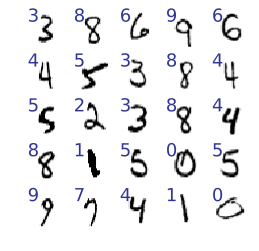

In [11]:
imgrid(images)

In [12]:
zeros  = images[targets==0] # find all "0" images
ones   = images[targets==1] # find all "1" images
sevens = images[targets==7] # find all "7" images

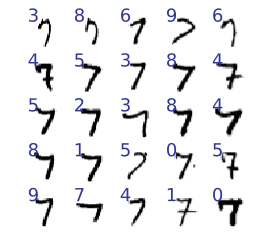

In [13]:
imgrid(sevens)

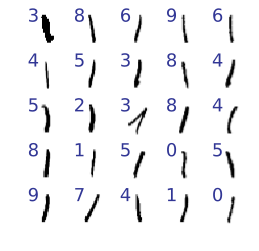

In [14]:
imgrid(ones)

In [15]:
np.unique(ones.iloc[1]) # greyscale values 0..1

array([0.        , 0.04296875, 0.05078125, 0.09375   , 0.09765625,
       0.140625  , 0.15625   , 0.16015625, 0.171875  , 0.27734375,
       0.296875  , 0.30078125, 0.37109375, 0.375     , 0.41015625,
       0.46484375, 0.4765625 , 0.52734375, 0.54296875, 0.546875  ,
       0.58203125, 0.5859375 , 0.6484375 , 0.66015625, 0.73046875,
       0.7578125 , 0.76171875, 0.76953125, 0.7890625 , 0.796875  ,
       0.80078125, 0.82421875, 0.8359375 , 0.8515625 , 0.890625  ,
       0.93359375, 0.96875   , 0.9765625 , 0.98046875, 0.9921875 ])

In [16]:
# combine 1s and 7s to get subset of data; ones' class is 0, sevens' class is 1
print(f"{len(ones)} ones and {len(sevens)} sevens")
X = np.concatenate([ones, sevens], axis=0)
y = np.concatenate([np.zeros(len(ones)), np.ones(len(sevens))], axis=0)

1064 ones and 1090 sevens


### Fit model

In [17]:
no_regularization = 1/1e100
score(X, y, LogisticRegression(C=no_regularization, solver='lbfgs'))

(0.4943122460824144, 0.4925754060324826)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
lgr = LogisticRegression(C=no_regularization, solver='lbfgs')
lgr.fit(X_train, y_train)
y_pred = lgr.predict(X_test)

What the predictions should be (0=one, 1=seven)

### Evaluating results

In [19]:
y_test

array([0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1.,
       1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0.,
       1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 1.

What we get (all class 0 or "ones"). dang.

In [20]:
y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [21]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
P = precision_score(y_test, y_pred)
R = recall_score(y_test, y_pred)
P, R

[[208   0]
 [223   0]]


/Users/parrt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.0, 0.0)

### Look at the regression coefficients

Ok, that's not good. They are all 0

In [22]:
coef = lgr.coef_[0,:]  # these come out as [nclasses-1, nfeatures]
coef[:100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Regularization

In [23]:
for pow in np.arange(10,-1,-1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    lmbda = np.power(10,pow)
    lm = LogisticRegression(C=1/lmbda, solver='lbfgs')
    lm.fit(X_train, y_train)
    y_pred = lm.predict(X_test)
#     cm = confusion_matrix(y_test, y_pred)
#     print(cm)
    P = precision_score(y_test, y_pred)
    R = recall_score(y_test, y_pred)
    P, R
    print(f"lambda={lmbda:>11} gets R^2 {lm.score(X_test, y_test):.2f}, precision={P:.2f}, recall={R:.2f}")

lambda=10000000000 gets R^2 0.45, precision=0.00, recall=0.00
lambda= 1000000000 gets R^2 0.47, precision=0.47, recall=1.00
lambda=  100000000 gets R^2 0.50, precision=0.50, recall=1.00
lambda=   10000000 gets R^2 0.51, precision=0.51, recall=1.00
lambda=    1000000 gets R^2 0.48, precision=0.48, recall=1.00
lambda=     100000 gets R^2 0.65, precision=0.56, recall=1.00


/Users/parrt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


lambda=      10000 gets R^2 0.97, precision=1.00, recall=0.94
lambda=       1000 gets R^2 0.98, precision=1.00, recall=0.97
lambda=        100 gets R^2 0.98, precision=1.00, recall=0.97
lambda=         10 gets R^2 0.99, precision=0.99, recall=0.99
lambda=          1 gets R^2 1.00, precision=1.00, recall=1.00


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lmbda = 0.1
lm = LogisticRegression(C=1/lmbda, solver='lbfgs')
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[205,   2],
       [  4, 220]])

### Look at the regression coefficients from regularization

In [25]:
coef = lm.coef_[0,:]
coef[0:50]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Text(0, 0.5, 'Regression coefficient value')

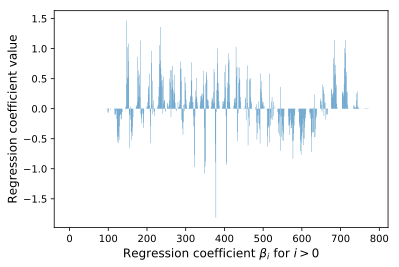

In [26]:
plt.bar(range(len(lm.coef_[0,:])),lm.coef_[0,:])
plt.xlabel("Regression coefficient $\\beta_i$ for $i>0$", fontsize=12)
plt.ylabel("Regression coefficient value", fontsize=12)